In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anvil
import geohash
from locationpublic import *
import os
import sys
import eurekacluster
import math
from motifanalysis import *
import motif2
import folium
from geopy.distance import vincenty
from collections import Counter

In [87]:
def compute_gyration_radius(significant_places_geo_hash, location_history_geohash):
    """
    This function computes the total radius of gyration and k-radius gyration for an individual
    based on visitied locations.
    
    The total radius of gyration is used to characterize the typical distance travelled by an individual.
    The k-radius of gyration is the radius of gyration computed over the k-th most frequent locations.
    
    Parameters:
    -----------
    
    significant_places_geo_hash: a list of strings
        Geohash strings that store the visited locations/significant locations.
    
    location_history_geohash: a list of strings
        A list of geohash values that represents the full location history/gps record of an indiviual in time series.
    
    returns:
    --------
    float:
        The total radius of gyration
    DataFrame:
        k-th radius of gyration in descending order of frequented locations
    DataFrame:
        info for significant locations including geohash values, gps coordinates, count, k-th radius of gyration
        
    """
    significant_places_gps = [geohash.decode(x) for x in significant_places_geo_hash]
    num_places = len(significant_places_gps)
    num_points = len(location_history_geohash)
    
    # construct a DataFrame to store significant places' info
    significant_places = pd.DataFrame(columns =['geo_hash','gps','count','cnt_pct','gyration_radius','k'])
    significant_places.geo_hash = significant_places_geo_hash
    significant_places.gps = significant_places_gps
    significant_places.ix[:,'count'] = [0] * num_places
    significant_places.ix[:,'gyration_radius'] = [0] * num_places
    significant_places = significant_places.set_index('geo_hash')
    
    cnt = Counter(location_history_geohash)
    for v in cnt:
        if v in significant_places.index.tolist():
            significant_places.ix[v,'count'] = cnt[v]
            significant_places.ix[v,'cnt_pct'] = cnt[v] / num_points
            
    significant_places = significant_places.sort_values(by = 'count',ascending = False)
    significant_places.ix[:,'k'] = [ x+1 for x in range(num_places)]
    
    # compute tatol radius of gyration
    N = sum(significant_places['count'].tolist())
    r_cm = np.mean(significant_places.gps.tolist(),axis = 0)
    temp_sum = 0
    for i in range(num_places):
        r = significant_places.ix[i,'gps']
        temp_sum += significant_places.ix[i,'count'] * vincenty(r,r_cm).km**2
    r_total = math.sqrt(1/N * temp_sum)
    
    # compute k-radius of gyration
    for i in range(1,num_places+1):
        N = sum(significant_places.ix[:i,'count'])
        r_cm = np.mean(significant_places.ix[:i,'gps'].tolist(),axis = 0)
        temp_sum = 0
        for j in range(i):
            r = significant_places.ix[j,'gps']
            temp_sum += significant_places.ix[j,'count'] * vincenty(r,r_cm).km**2
        significant_places.ix[i-1,'gyration_radius'] = math.sqrt(1/N * temp_sum)
    

    
    if len(significant_places_geo_hash)==1:
        significant_places['ratio_k'] = 1
    else:
        significant_places['ratio_k'] = [ x/r_total for x in significant_places.gyration_radius.tolist()]
    
    return(r_total,significant_places.ix[:,['gyration_radius','k','ratio_k']].set_index('k'),significant_places)

In [89]:
def generate_recurrent_ratio(path,uids):
    uids = pd.read_csv(path+uids,usecols = ['uid'])
    uids = uids.uid.tolist()
    max_l = 0
    k_gyration = []
    k_gyration_pct = []
    uids2 = uids
    for uid in uids:
        curr_uid = path + uid
        eureka = pd.read_csv(curr_uid, usecols=['time', 'longitude', 'latitude','geo_hash'])
#         eureka = anvil.api.convert_time_zone(df = eureka,
#                                              column_name = 'time',
#                                              should_localize = 'America/New_York',
#                                              sort_index = True, 
#                                              to_timezone = 'America/New_York')
        eureka = anvil.api.convert_time_zone(df = eureka,column_name = 'time')
        eureka_hash = pd.Series(filter_out_rare_points(eureka.geo_hash))
        l = eureka_hash.dropna().unique().tolist()
        if len(l)==0:
            uids2.remove(uid)
            continue
        r_total, r_k, df = compute_gyration_radius(l,eureka.geo_hash.tolist())
        k_gyration.append(r_k.gyration_radius)
        k_gyration_pct.append(r_k.ratio_k)
        curr_l = len(r_k.ratio_k)
        if curr_l > max_l:
            max_l = curr_l
    ret_v = pd.DataFrame(k_gyration,index = uids2,columns = list(range(1,max_l+1)))
    ret_pct = pd.DataFrame(k_gyration_pct,index = uids2,columns = list(range(1,max_l+1)))
    return ret_v, ret_pct

In [90]:
v,r = generate_recurrent_ratio('./precision-7/','uids.csv')

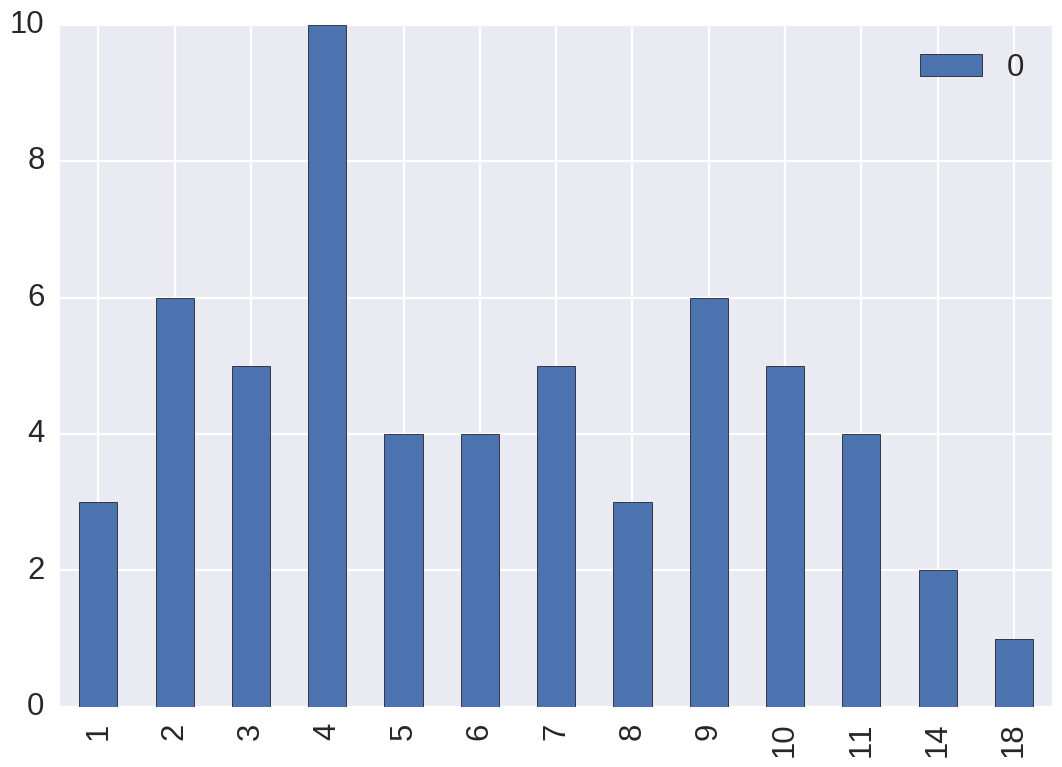

In [157]:
m = v.as_matrix()
n = []
for i in m:
    t = [x for x in i if ~np.isnan(x)]
    n.append(len(t))
plt.clf()
counter = Counter(n)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

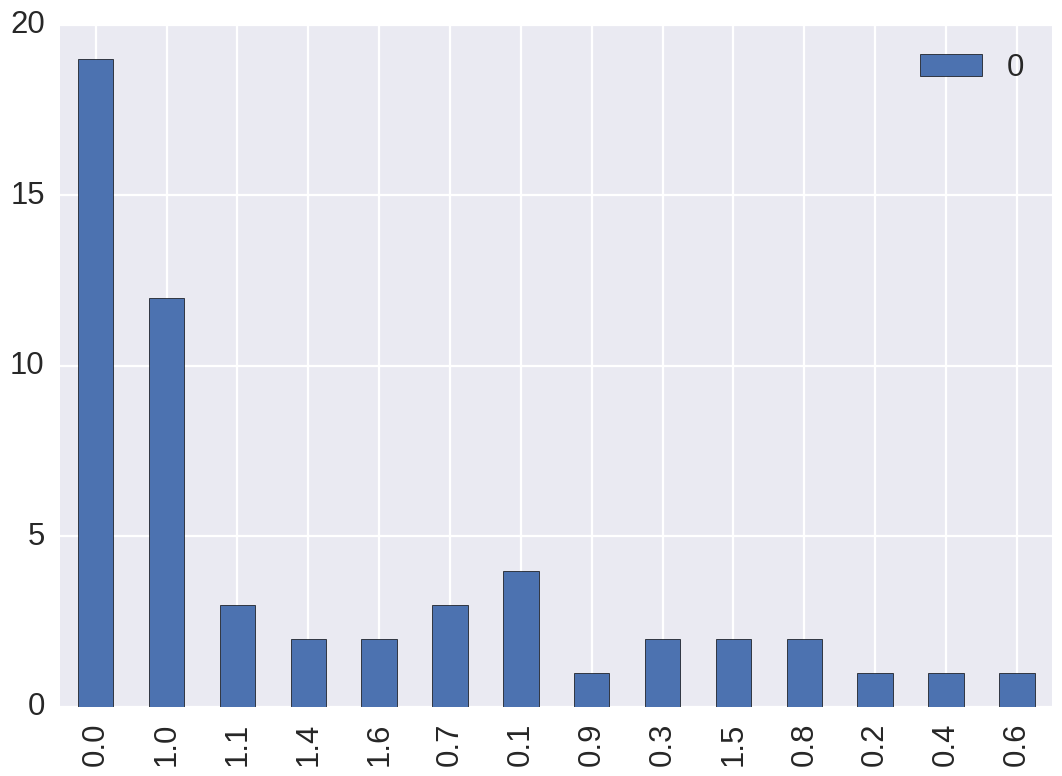

In [125]:
# plot for k = 2
r2 = [round(x,1) for x in r.ix[:,2].dropna().tolist()]
plt.clf()
counter = Counter(r2)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

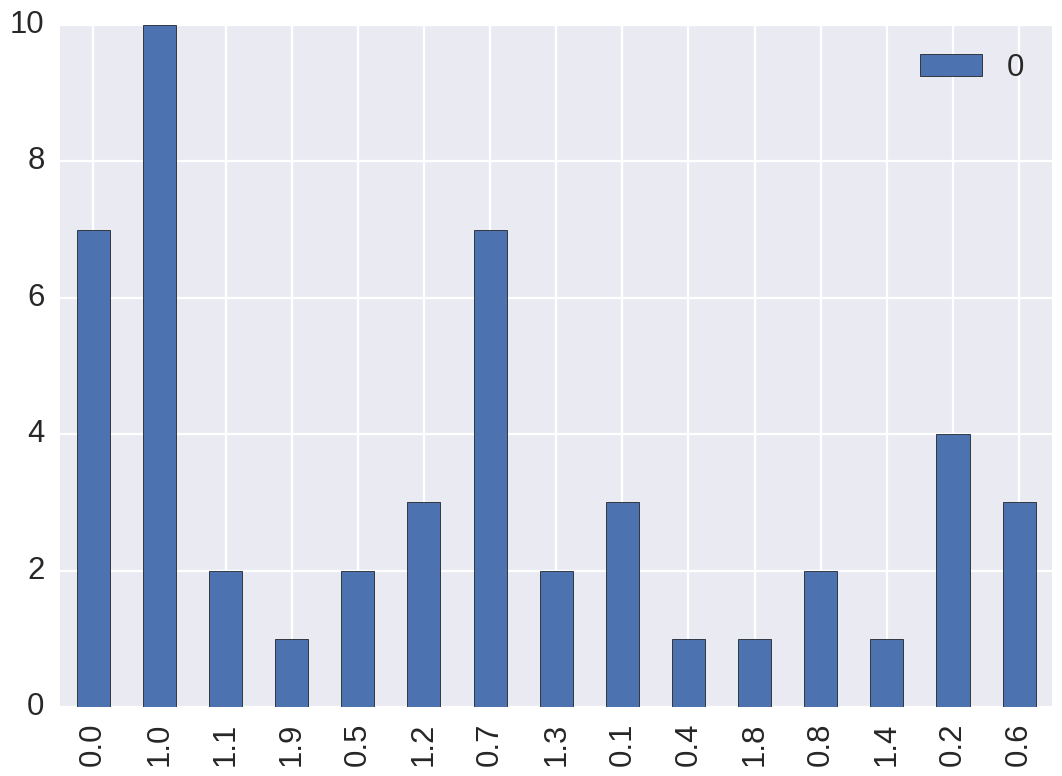

In [163]:
# plot for k = 3
r2 = [round(x,1) for x in r.ix[:,3].dropna().tolist()]
plt.clf()
counter = Counter(r2)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

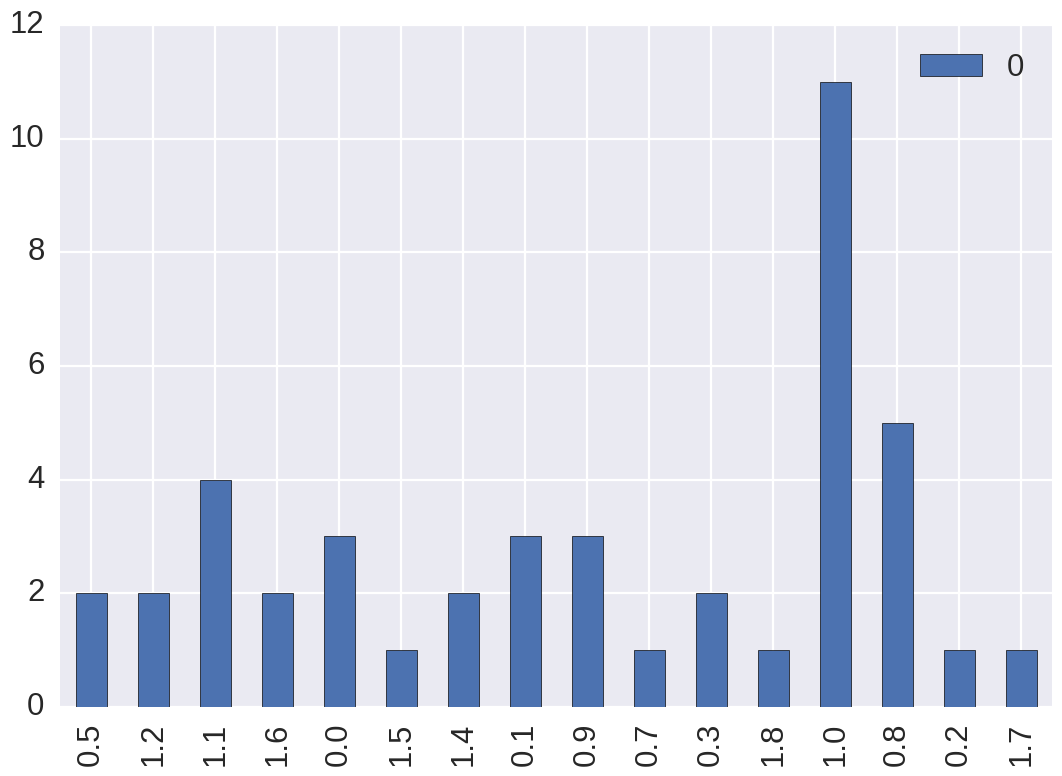

In [162]:
# plot for k = 4
r2 = [round(x,1) for x in r.ix[:,4].dropna().tolist()]
plt.clf()
counter = Counter(r2)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

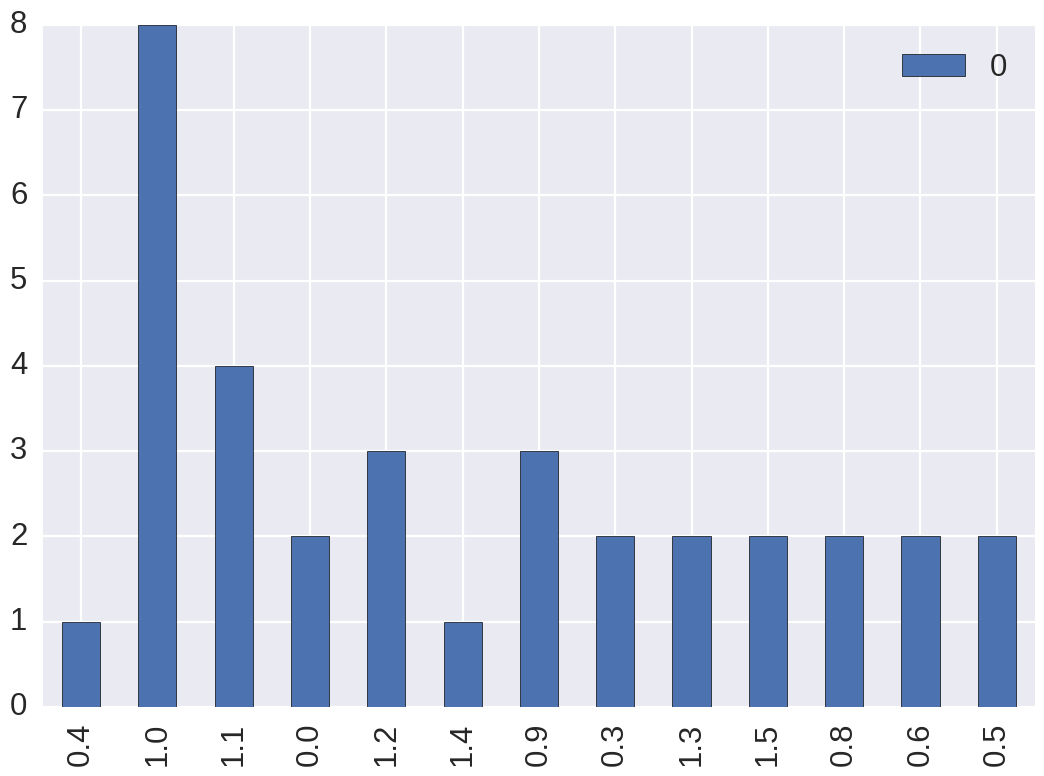

In [161]:
# plot for k = 5
r2 = [round(x,1) for x in r.ix[:,5].dropna().tolist()]
plt.clf()
counter = Counter(r2)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

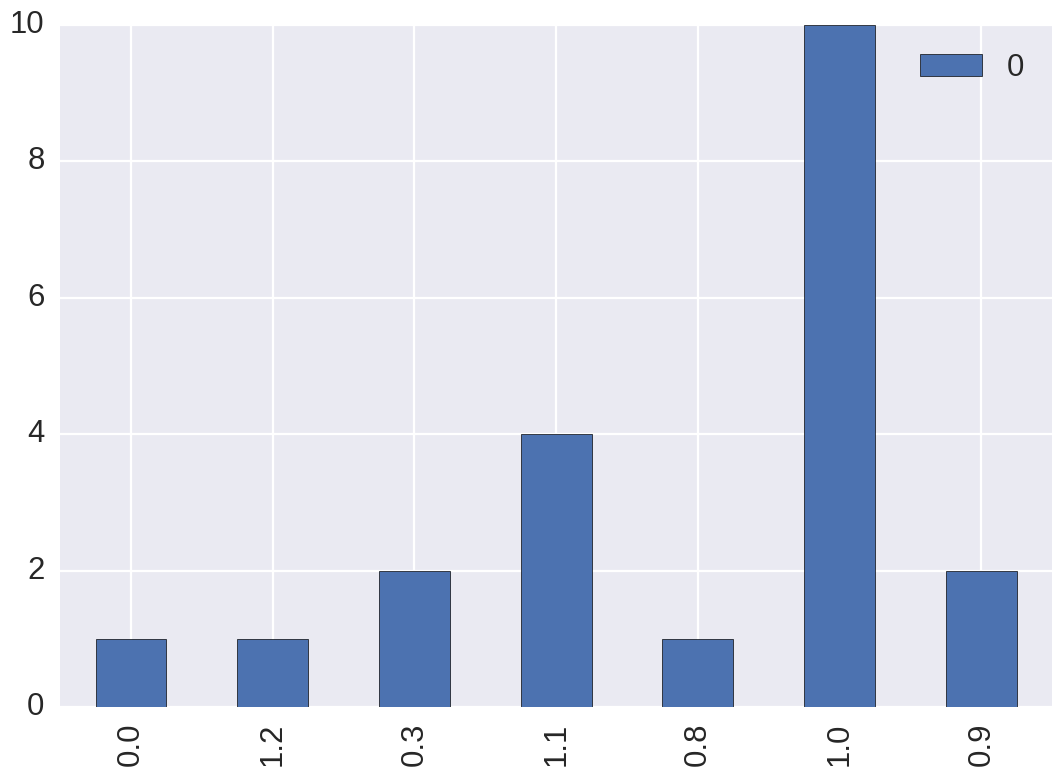

In [160]:
# plot for k = 8
r2 = [round(x,1) for x in r.ix[:,8].dropna().tolist()]
plt.clf()
counter = Counter(r2)
df = pd.DataFrame.from_dict(counter, orient = 'index')
df.plot(kind = 'bar')
plt.show()

In [13]:
uid = 'u066_rct@eureka.csv'
eureka = pd.read_csv(uid, usecols=['time', 'longitude', 'latitude'])
num_points = len(eureka)

In [16]:
# eureka = anvil.api.convert_time_zone(df = eureka,column_name = 'time',should_localize = 'America/New_York',
#                                     sort_index = True, to_timezone = 'America/New_York')
eureka = anvil.api.convert_time_zone(df = eureka,column_name = 'time')

In [17]:
eureka['geo_hash'] = compute_geo_hash(eureka, lat_c='latitude',lon_c='longitude', precision=7)
eureka_hash = pd.Series(filter_out_rare_points(eureka.geo_hash))
l = eureka_hash.dropna().unique().tolist()

In [54]:
r_total, r_k, df = compute_gyration_radius(l,eureka.geo_hash.tolist())

In [55]:
print(r_total)
print()
print(r_k)
print()
print(df)

141.45636369259844

   gyration_radius   ratio_k
k                           
1         0.000000  0.000000
2       174.433175  1.233124
3       118.816577  0.839952
4        92.143053  0.651389
5       141.456364  1.000000

                                              gps  count     cnt_pct  \
geo_hash                                                               
dr5xdrx   (40.73524475097656, -73.71894836425781)  10205     0.92445   
dru87xe   (43.67958068847656, -72.26325988769531)    152   0.0137694   
dr5xdrw   (40.73524475097656, -73.72032165527344)    129   0.0116858   
dr5xdrz   (40.73661804199219, -73.71894836425781)    108  0.00978349   
dru87xd   (43.67958068847656, -72.26463317871094)     79  0.00715645   

          gyration_radius  k   ratio_k  
geo_hash                                
dr5xdrx          0.000000  1  0.000000  
dru87xe        174.433175  2  1.233124  
dr5xdrw        118.816577  3  0.839952  
dr5xdrz         92.143053  4  0.651389  
dru87xd        141.456364

In [14]:
uids = pd.read_csv('./precision-7/uids.csv',usecols = ['uid'])
uids = uids.uid.tolist()
prefix = './precision-7/'

In [24]:
u = prefix + uids[1]
print(u)

./precision-7/u006.csv


In [25]:
eureka = pd.read_csv(u, usecols=['time', 'longitude', 'latitude','geo_hash'])

In [26]:
eureka = anvil.api.convert_time_zone(df = eureka,column_name = 'time',should_localize = 'America/New_York',
                                    sort_index = True, to_timezone = 'America/New_York')
eureka_hash = pd.Series(filter_out_rare_points(eureka.geo_hash))
l = eureka_hash.dropna().unique().tolist()

In [27]:
l

['dr5x3wx', 'dr5x3y2', 'dr5x3y0', 'dr5x3wr', 'dhwuydt']

In [31]:
r_total, r_k, df = compute_gyration_radius(l,eureka.geo_hash.tolist())
print(r_total)
print()
print(r_k)

380.28289915908306

   gyration_radius   ratio_k
k                           
1         0.000000  0.000000
2         0.163174  0.000429
3         0.166165  0.000437
4       453.642883  1.192909
5       380.282899  1.000000


In [32]:
r_k['uid'] = u
print(r_k)

   gyration_radius   ratio_k                     uid
k                                                   
1         0.000000  0.000000  ./precision-7/u006.csv
2         0.163174  0.000429  ./precision-7/u006.csv
3         0.166165  0.000437  ./precision-7/u006.csv
4       453.642883  1.192909  ./precision-7/u006.csv
5       380.282899  1.000000  ./precision-7/u006.csv


In [60]:
a = [1,2,3]
b = [2,3,4]
c = [1,2]
d = [1,2,3,4,5]
e = pd.DataFrame([a,b,c,d],index = list('abcd'), columns = list(range(1,5+1)))

In [61]:
e

,1,2,3,4,5
a,1,2,3.0,NaN,NaN
b,2,3,4.0,NaN,NaN
c,1,2,NaN,NaN,NaN
d,1,2,3.0,4.0,5.0


In [45]:
e.columns = list(range(1,6))
print(e)

   1  2    3    4    5
0  1  2  3.0  NaN  NaN
1  2  3  4.0  NaN  NaN
2  2  3  4.0  NaN  NaN
3  1  2  NaN  NaN  NaN
4  1  2  3.0  4.0  5.0


In [51]:
e.ix[:,3].dropna().tolist()

[3.0, 4.0, 4.0, 3.0]